In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5ce9deecb7f94df6aa2f59dd34e0d4bf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='iEQ9Bf4cNaCK_mKp01G2lp9MuDpNDDM9ld5ZYhxgNYOQ',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5ce9deecb7f94df6aa2f59dd34e0d4bf.get_object(Bucket='iristest-donotdelete-pr-racvdgxspxeckz',Key='Iris.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
import tensorflow as tf 

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6065545200475422308
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2603990549859102470
physical_device_desc: "device: XLA_CPU device"
]


In [8]:
#품종 column을 one-hot-encode
iris_data_one_hot_encoded = pd.get_dummies(df_data_2)
iris_data_one_hot_encoded.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,1,5.1,3.5,1.4,0.2,1,0,0
1,2,4.9,3.0,1.4,0.2,1,0,0
2,3,4.7,3.2,1.3,0.2,1,0,0
3,4,4.6,3.1,1.5,0.2,1,0,0
4,5,5.0,3.6,1.4,0.2,1,0,0


## Visualize the Data

In [10]:
import matplotlib.pyplot as plt

names = {'Iris-setosa','Iris-versicolor','Iris-virginica'}
feature_names = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']
labels=df_data_2.iloc[:,5]

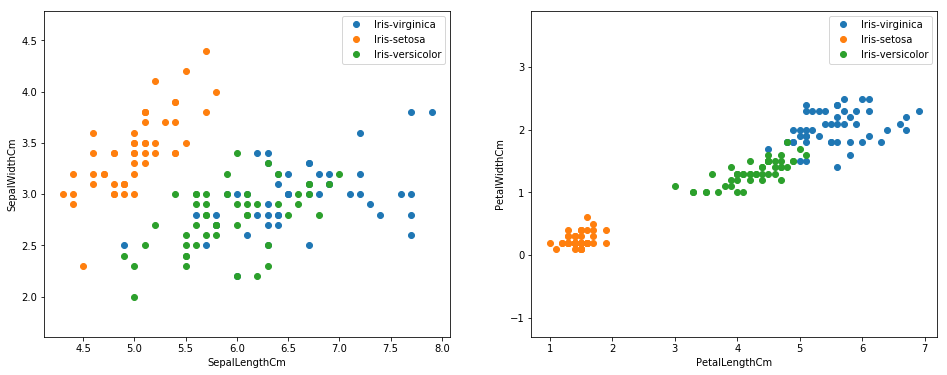

In [13]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = df_data_2[labels== target_name]
    plt.plot(X_plot.iloc[:, 1], X_plot.iloc[:, 2], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();


plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = df_data_2[labels== target_name]
    plt.plot(X_plot.iloc[:, 3], X_plot.iloc[:, 4], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [14]:
#전체 데이터를 80%은 트레이닝 20% 테스트로 쪼갬
iris_train_data = iris_data_one_hot_encoded.sample(frac=0.8, random_state=200)
iris_test_data = iris_data_one_hot_encoded.drop(iris_train_data.index)

In [15]:
#input은 꽃잎의 너비와길이, 꽃받침의 너비와길이
#output은 세개중 하나로
iris_train_input_data = iris_train_data.filter(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])
iris_train_label_data = iris_train_data.filter(['Species_Iris-setosa', 'Species_Iris-versicolor', 'Species_Iris-virginica'])
iris_test_input_data = iris_test_data.filter(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])
iris_test_label_data = iris_test_data.filter(['Species_Iris-setosa', 'Species_Iris-versicolor', 'Species_Iris-virginica'])


In [16]:
#x는 input값을 위한 placeholder
#w는 가중치
#b는 편차
#y는 트레이닝해서 나온 결과(가설)
#y_는 진짜 결과값
x = tf.placeholder(tf.float32,[None, 4])
W = tf.Variable(tf.zeros([4, 3]))
b = tf.Variable(tf.zeros([3]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 3])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#cross_entropy를 cost함수로
cross_entropy  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=tf.matmul(x,W)+b))

In [18]:
#cost를 최소화
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

In [19]:
sess = tf.InteractiveSession()

In [21]:
#30,000번 학습
#tf.global_variables_initializer().run()
epoch_history = []
loss_history = []

sess.run(tf.global_variables_initializer())
for _ in range(30000):
    #Usually send batches to the training step. But since the dataset is small sending all
    l,a=sess.run([cross_entropy,train_step], feed_dict={x: iris_train_input_data, y_: iris_train_label_data})
    epoch_history.append(_)
    loss_history.append(l)

print("trained")

trained


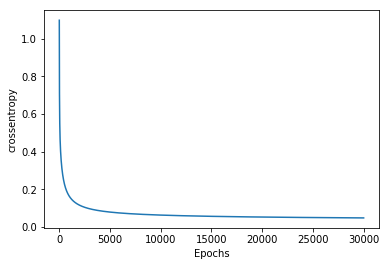

In [22]:
#Draw Cross Entropy Graph
plt.xlabel('Epochs')
plt.ylabel('crossentropy')


# Show the cross_entropy
plt.plot(epoch_history, loss_history)

In [23]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
#정확도
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy : ', sess.run(accuracy, feed_dict={x: iris_test_input_data, y_: iris_test_label_data}))

Accuracy :  0.96666664
